In [36]:
import numpy as np
import random
import scipy.integrate as scp
import numpy.random as rnd
import time
import matplotlib.pyplot as plt
import numpy.random as rnd
import copy
from matplotlib.pyplot import figure
from pyomo.environ import *
from pyomo.dae import *
import pandas as pd
import pickle
import scipy.stats
from math import comb
from scipy.integrate import odeint

import glob, os

Gneneration of 4 sets of experimental data with different nitrate and light intensity, varies from low to high, number of datapoints for each exps is 17, noise level is 5% of means.

In [37]:
''' Data treatment'''
def save_pkl(item, fname):
    sn = 'data/' + fname
    with open(sn, 'wb') as handle:
        pickle.dump(item, handle) #, protocol=pickle.HIGHEST_PROTOCOL)
    print(f'File saved at: {sn}')
    return None
# return None

def load_pkl(fname):
    with open(fname, 'rb') as handle:
        ans = pickle.load(handle)
    print(f'Loaded from: {fname}')
    return ans

In [38]:
def to_dict(x,dt):
    obs = list(x)
    # tp = list(time)
    dicx = {}
    for i in range(len(x)):
        dicx[dt*i] = obs[i]            # change thye value of 38.4
    return dicx

def get_grad(x, t):
    dxdt = [[],[],[],[]]
    for n in range(x.shape[0]):
        for i in range(len(x[0]) - 1):
            dxdt[n].append((x[n][i + 1] - x[n][i])/(t[i + 1] - t[i]))
        dxdt[n].append(dxdt[n][-1])
    return dxdt


In [39]:
tf    = 16.*24.
steps_= 16
dt    = tf/steps_


num_N = 4
tf_N  = tf/(num_N)
dstep_N = int(tf_N/dt)# this is the number of steps in each interval between chaning the fedding rate

In [40]:
t = np.linspace(0, 16*24, num=16+1)

In [41]:
# sobol for 4 experiments, for both N and IT.
from scipy.stats import qmc
sampler = qmc.Sobol(d=2, scramble=False)
sample = sampler.random_base2(m=2)
l_bounds = [0.1,100]   # X,N
u_bounds = [0.2,200]
operation_con = qmc.scale(sample,l_bounds,u_bounds)

In [42]:
operation_con 

array([[1.00e-01, 1.00e+02],
       [1.50e-01, 1.50e+02],
       [1.75e-01, 1.25e+02],
       [1.25e-01, 1.75e+02]])

In [43]:
# # sobol for 16 IT.
# from scipy.stats import qmc
# sampler_I = qmc.Sobol(d=1, scramble=False)
# sample_I = sampler_I.random_base2(m=4)

# l_bounds_I = [50]
# u_bounds_I = [600]
# I_con = qmc.scale(sample_I,l_bounds_I,u_bounds_I)

In [44]:
# sobol for 16 IT. seperate from the initial condition since the feeding concentration of N should not be as high as the initial concentration in the reactor
from scipy.stats import qmc
sampler_N = qmc.Sobol(d=1, scramble=False)
sample_N = sampler_N.random_base2(m=4)

l_bounds_N = [1*1e-2]
u_bounds_N = [10*1e-2]
N_con = qmc.scale(sample_N,l_bounds_N,u_bounds_N)

In [45]:
N_con

array([[0.01    ],
       [0.055   ],
       [0.0775  ],
       [0.0325  ],
       [0.04375 ],
       [0.08875 ],
       [0.06625 ],
       [0.02125 ],
       [0.026875],
       [0.071875],
       [0.094375],
       [0.049375],
       [0.038125],
       [0.083125],
       [0.060625],
       [0.015625]])

In [46]:
N_con = [N_con[i:i+4] for i in range(0, len(N_con), 4)]

In [47]:
N_con

[array([[0.01  ],
        [0.055 ],
        [0.0775],
        [0.0325]]),
 array([[0.04375],
        [0.08875],
        [0.06625],
        [0.02125]]),
 array([[0.026875],
        [0.071875],
        [0.094375],
        [0.049375]]),
 array([[0.038125],
        [0.083125],
        [0.060625],
        [0.015625]])]

In [48]:
# N_all = []
# for i in range(4):
#     operation_con_i = operation_con[i][1]
#     N_con_i = N_con[i]
#     concatenated_array = np.vstack((operation_con_i, N_con_i))
#     N_all.append(concatenated_array)

In [49]:
def dic_F_in_I(no_data,num_u,u_con):
    u_test = np.ones([no_data,num_u])
    for i in range(len(t)):
        if t[i] >=0 and t[i] <=tf_N:
            u_test[i] = u_con[0]
        if t[i] >tf_N and t[i] <=2*tf_N:
            u_test[i] = u_con[1]
        if t[i] >2*tf_N and t[i] <=3*tf_N:
            u_test[i] = u_con[2]
        if t[i] >3*tf_N and t[i] <=4*tf_N:
            u_test[i] = u_con[3]
    # Insert the new element at the beginning of the array
    # u_test = np.vstack((new_element,u_test))

    F_in_dic = to_dict(u_test.T[0],dt)
    # I_dic    = to_dict(u_test.T[1],dt)

    return F_in_dic

In [50]:
N_con

[array([[0.01  ],
        [0.055 ],
        [0.0775],
        [0.0325]]),
 array([[0.04375],
        [0.08875],
        [0.06625],
        [0.02125]]),
 array([[0.026875],
        [0.071875],
        [0.094375],
        [0.049375]]),
 array([[0.038125],
        [0.083125],
        [0.060625],
        [0.015625]])]

In [51]:
u_dic1 = dic_F_in_I(17,1,N_con[0])
u_dic2 = dic_F_in_I(17,1,N_con[1])
u_dic3 = dic_F_in_I(17,1,N_con[2])
u_dic4 = dic_F_in_I(17,1,N_con[3])

In [52]:
u_dic2 

{0.0: 0.043750000000000004,
 24.0: 0.043750000000000004,
 48.0: 0.043750000000000004,
 72.0: 0.043750000000000004,
 96.0: 0.043750000000000004,
 120.0: 0.08875000000000001,
 144.0: 0.08875000000000001,
 168.0: 0.08875000000000001,
 192.0: 0.08875000000000001,
 216.0: 0.06625,
 240.0: 0.06625,
 264.0: 0.06625,
 288.0: 0.06625,
 312.0: 0.02125,
 336.0: 0.02125,
 360.0: 0.02125,
 384.0: 0.02125}

In [53]:
# N_range = load_pkl('operation data/N_range.pkl')
# I0_range = load_pkl('operation data/I0_range.pkl')



# I1 = I0_range[0]
# I2 = I0_range[1]
# I3 = I0_range[2]

# I_max = np.max([I1,I2,I3])

# I_all = np.array([I1,I2,I3])

In [54]:

# def model(state, t, para):
#     # Internal definitions

    
#     # State vector
#     x = state[0]
#     n = state[1]
#     q = state[2]
#     f = state[3]

#     I0      = para['I0']
    
#     # Parameters

#     kq      = para['kq']
#     ud      = para['ud']
#     un      = para['un']
#     kn      = para['kn']
#     theta   = para['theta']
#     gamma   = para['gamma']
#     epsilon = para['epsilon']
    
#     tau     = para['tau']
#     delta   = para['delta']
#     phi     = para['phi']
#     ks      = para['ks']
#     ki      = para['ki']
#     alpha   = para['alpha']
#     belta   = para['belta']
#     uM      = para['uM']  
    
    
    
#     # Algebraic equations, calculation of um
#         #Initial of L and I
#     L         = 4.4E-2
#     # I0      = 80
#     def I_e(z):

#         I_z   = I0*np.exp(-(alpha*x+belta)*z) 
#         I     = uM*I_z/(I_z+ks+I_z**2/ki)
#         return I





#     um    = scp.quad(I_e, 0, L)
#     um    = um[0]/L


#     u0     = um*(1-kq/q)
    
    
#     # Differential equations
#     dev_x  = u0*x-ud*x
#     dev_n  = -un*(n/(n+kn))*x
#     dev_q  = un*(n/(n+kn)) - (um*(1-(kq/q))-ud)*q
#     dev_f  = um*(theta*q-epsilon*f)*(1-(kq/q)) - gamma*un*(n/(n+kn))+ud*epsilon*f
        
#     # fluorescence
#     Y      = (np.exp(tau*q)/(np.exp(tau*q)+delta))+phi

#     return np.array([dev_x,dev_n,dev_q,dev_f],dtype='float64').flatten()


# # Simulation
# def simulation(model, steps, tf, x0,para):
#     t_eval        = np.linspace(0,tf,steps+1)
#     sol           = odeint(model,x0, t_eval, args = (para,)).T
        
#     return sol,t_eval

In [55]:
# Data generation #
class ModelIntegration:
    '''
    This files integrates the model.
    
     model: this is were the model should be changed 
    '''
    
    # --- initializing model --- #
    def __init__(self, parameters):
        
        # Object variable definitions

        self.parameters = parameters
    # --- dynamic model definition --- #    
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        
        # define controls here

        # state vector
        Cx  = state[0]
        Cn  = state[1]
        V   = state[2]
                # define controls here
        FCn    = params['FCn']
        N_in   = params['N_in']
        # print(FCn,'Fcn')
        
        # parameters
        u_m  = params['u_m'] 
        K_N  = params['K_N']
        u_d  = params['u_d']
        Y_nx = params['Y_nx']
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = -FCn/V*Cx + u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn*(N_in-Cn)/V
        dev_V   = FCn
        
        # print("Shape of dev_Cx:", np.shape(dev_Cx))
        # print("Shape of dev_Cn:", np.shape(dev_Cn))
        
        return np.array([dev_Cx, dev_Cn,dev_V],dtype='float64')
    
    # --- simulation --- #
    def simulation(self, steps, tf, x0):
        '''
        simulate for a number of steps to collect data, and a final time
        '''

        # external definitions
        self.x0, self.tf = x0, tf

        # internal definitions
        model = self.model
        dt    = tf/(steps)
        
        # compile state trajectories
        xt = np.zeros((x0.shape[0],steps+1))
        tt = np.zeros((steps+1))
        
        # initialize simulation
        current_state = x0
        xt[:,0]       = current_state
        tt[0]         = 0.
        
        # simulation
        for s in range(steps):
            ode           = scp.ode(model)                  # define ode
            ode.set_integrator('lsoda', nsteps=3000)        # define integrator
            ode.set_initial_value(current_state, dt)        # set initial value
            current_state = list(ode.integrate(ode.t + dt)) # integrate system
            xt[:,s+1]     = current_state                   # add current state
            tt[s+1]       = (s+1)*dt
        
        return xt, tt


In [56]:
def train_data_generation(parameter, initial_c,N_all):
    all_xt = []
    all_pe = []
    # all_tt = []

    for i in range(len(N_all)):
        parameter['FCn'] = N_all[i]
        print(parameter['FCn'],'FCn')
        m            = ModelIntegration(parameter)
        xt_i, tt_i       = m.simulation(dstep_N,tf_N,initial_c) 
        # xt_i, tt_i       = simulation(model, dstep_I,tf_I, initial_c,parameter)
        # print(xt_i,'xt_i')
        all_xt.append(xt_i)
        # all_tt.append(tt_i)
        new_init = np.zeros(3)
        for j in range(3):
            new_init[j] = xt_i[j][-1]
        initial_c = new_init
        # print(initial_c1,'initial_c1')

        all_pe.append(parameter.copy())

    for i in range(1,len(all_xt)):
        all_xt[i] = np.delete(all_xt[i], 0, axis=1)

        # all_tt[i] = np.delete(all_tt[i], 0, axis=1)
    # print(all_xt,'all_xt')
    xt = all_xt[0]
    # tt = all_tt[0]

    # Iterate through the remaining arrays and concatenate them
    for i in all_xt[1:]:
        xt = np.concatenate((xt, i), axis=1)  # Concatenate along the rows

    
    mean_x = np.zeros(xt.shape[0])
    for i in range(xt.shape[0]):
        mean_x[i]=np.mean(xt[i])
        
    mean_x    = mean_x*0.05
    std_value = mean_x

    x_noise      = np.random.normal(0,mean_x[0],xt.shape[1])
    x_noise[0]   = 0
    n_noise      = np.random.normal(0,mean_x[1],xt.shape[1])
    n_noise[0]   = 0

    V_noise      = np.random.normal(0,0,xt.shape[1])

    # q_noise      = np.random.normal(0,mean_x[2],xt.shape[1])
    # q_noise[0]   = 0
    # f_noise      = np.random.normal(0,mean_x[3],xt.shape[1])
    # f_noise[0]   = 0 

    obs          = np.array([x_noise,n_noise,V_noise])
    xobs         = xt+obs

    for i in range(xobs.shape[0]):
        for j in range(len(xobs[i])):
            if xobs[i][j]<0:
                xobs[i][j] = 1E-7
    for i in range(xobs.shape[1]):
        if xobs[0][i]<0:
            xobs[0][i] = 1e-7
        if xobs[1][i]<0:
            xobs[1][i] = 1e-7

    return xt,xobs,std_value

In [57]:
#experiment 1

p1  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49,'FCn':N_con[0][0],'N_in':100}
initial_c1 =  np.array([operation_con[0][0],operation_con[0][1],10])
operation_con[0][0]

xt1,xobs1,std_value1 = train_data_generation(p1, initial_c1,N_con[0])


[0.01] FCn
[0.055] FCn
[0.0775] FCn
[0.0325] FCn


In [58]:
(xt1>= 0).all()

True

In [76]:
xt1[2][-1]

26.80000000000001

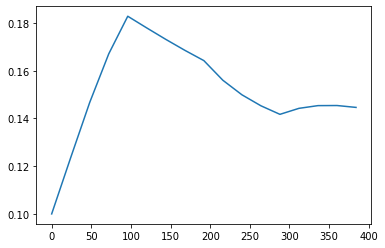

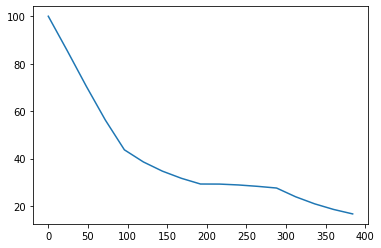

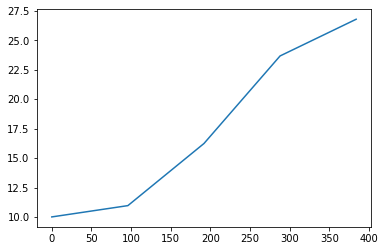

In [59]:
for i in range(xt1.shape[0]):
    plt.figure()
    plt.plot(t,xt1[i])
    plt.show()

In [60]:
#experiment 2

p2  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49,'FCn':N_con[1][0],'N_in':100}
initial_c2 =  np.array([operation_con[1][0],operation_con[1][1],10])

xt2,xobs2,std_value2 = train_data_generation(p2, initial_c2,N_con[1])




[0.04375] FCn
[0.08875] FCn
[0.06625] FCn
[0.02125] FCn


In [61]:
(xt2>= 0).all()

True

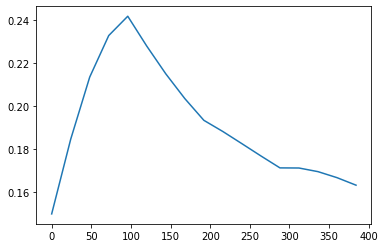

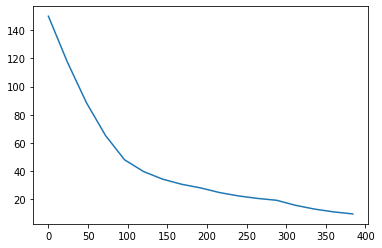

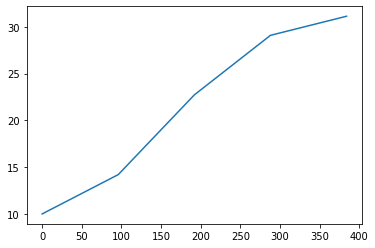

In [62]:
for i in range(xt2.shape[0]):
    plt.figure()
    plt.plot(t,xt2[i])
    plt.show()

In [63]:
#experiment 3

p3  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49,'FCn':N_con[2][0],'N_in':100}
initial_c3 =  np.array([operation_con[2][0],operation_con[2][1],10])

xt3,xobs3,std_value3 = train_data_generation(p3, initial_c3,N_con[2])




[0.026875] FCn
[0.071875] FCn
[0.094375] FCn
[0.049375] FCn


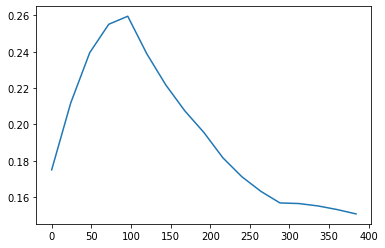

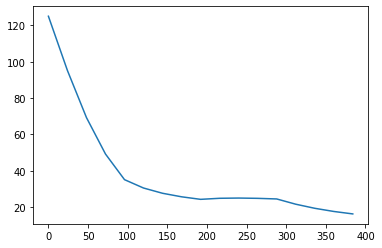

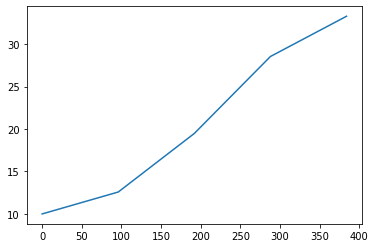

In [64]:
for i in range(xt3.shape[0]):
    plt.figure()
    plt.plot(t,xt3[i])
    plt.show()

In [66]:
#experiment 4

p4  = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49,'FCn':N_con[3][0],'N_in':100}
initial_c4 =  np.array([operation_con[3][0],operation_con[3][1],10])

xt4,xobs4,std_value4 = train_data_generation(p4, initial_c4,N_con[3])



[0.038125] FCn
[0.083125] FCn
[0.060625] FCn
[0.015625] FCn


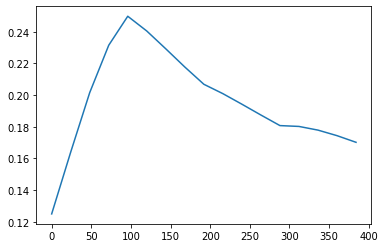

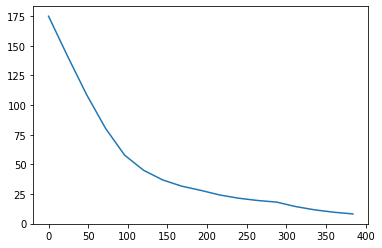

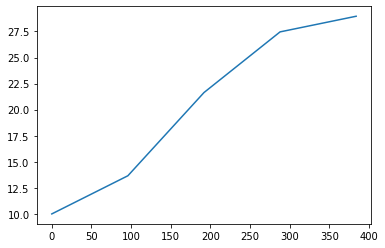

In [67]:
for i in range(xt4.shape[0]):
    plt.figure()
    plt.plot(t,xt4[i])
    plt.show()

In [22]:
xt1

array([[1.00000000e-01, 1.29724658e-01, 1.68593018e-01, 2.16192000e-01,
        2.69477050e-01, 3.55828262e-01, 5.04682907e-01, 6.99369184e-01,
        8.85678533e-01, 1.03975520e+00, 1.15285430e+00, 1.21204408e+00,
        1.23496221e+00, 1.15451521e+00, 1.03650827e+00, 9.50777572e-01,
        8.94791172e-01],
       [1.00000000e+02, 1.07418084e+02, 1.09128295e+02, 1.04640542e+02,
        9.46059241e+01, 1.71528307e+02, 2.06311083e+02, 1.96135753e+02,
        1.57036570e+02, 1.52458988e+02, 1.34514570e+02, 1.20189507e+02,
        1.12754850e+02, 5.52336849e+01, 4.78274040e+01, 5.01498846e+01,
        5.37224676e+01]])

In [23]:
xt1.shape

(2, 17)

In [68]:
data_init   = {None: dict(t       = {None: list(t)},
                          tm      = {None: list(t)},
                          x1_noise = to_dict(xobs1[0],dt),
                          n1_noise = to_dict(xobs1[1],dt),
                          x2_noise = to_dict(xobs2[0],dt),
                          n2_noise = to_dict(xobs2[1],dt),
                          x3_noise = to_dict(xobs3[0],dt),
                          n3_noise = to_dict(xobs3[1],dt),
                          x4_noise = to_dict(xobs4[0],dt),
                          n4_noise = to_dict(xobs4[1],dt))}

In [69]:
data_init

{None: {'t': {None: [0.0,
    24.0,
    48.0,
    72.0,
    96.0,
    120.0,
    144.0,
    168.0,
    192.0,
    216.0,
    240.0,
    264.0,
    288.0,
    312.0,
    336.0,
    360.0,
    384.0]},
  'tm': {None: [0.0,
    24.0,
    48.0,
    72.0,
    96.0,
    120.0,
    144.0,
    168.0,
    192.0,
    216.0,
    240.0,
    264.0,
    288.0,
    312.0,
    336.0,
    360.0,
    384.0]},
  'x1_noise': {0.0: 0.1,
   24.0: 0.12555868195053133,
   48.0: 0.1321941449675189,
   72.0: 0.17837443692420754,
   96.0: 0.18631123788763315,
   120.0: 0.18233709244702992,
   144.0: 0.16934791693198747,
   168.0: 0.17773395854681903,
   192.0: 0.1726984078243621,
   216.0: 0.1530911012065377,
   240.0: 0.15498485297992384,
   264.0: 0.13106517877271762,
   288.0: 0.13831429066252293,
   312.0: 0.14263076680986586,
   336.0: 0.14115430066250523,
   360.0: 0.15095857455940037,
   384.0: 0.1577460564485866},
  'n1_noise': {0.0: 100.0,
   24.0: 84.55265425731078,
   48.0: 70.03831939280748,
   72.0:

In [32]:
operation_con[0]

array([  0.1, 100. ])

In [71]:
operation_con

array([[1.00e-01, 1.00e+02],
       [1.50e-01, 1.50e+02],
       [1.75e-01, 1.25e+02],
       [1.25e-01, 1.75e+02]])

In [70]:
N_in = 100

In [72]:
save_pkl(xobs1,'xobs1.pkl')
save_pkl(xobs2,'xobs2.pkl')
save_pkl(xobs3,'xobs3.pkl')
save_pkl(xobs4,'xobs4.pkl')
save_pkl(N_con,'Fcn.pkl')
save_pkl(N_in,'N_in.pkl')

save_pkl(tf_N,'tf_N.pkl')
save_pkl(operation_con,'operation_con.pkl')
# save_pkl(I0_range,'I0_range.pkl')

save_pkl(t,'tt1.pkl')
save_pkl(std_value1,'std_value1.pkl')
save_pkl(std_value2,'std_value2.pkl')
save_pkl(std_value3,'std_value3.pkl')
save_pkl(std_value4,'std_value4.pkl')

save_pkl(data_init,'data_init.pkl')


File saved at: data/xobs1.pkl
File saved at: data/xobs2.pkl
File saved at: data/xobs3.pkl
File saved at: data/xobs4.pkl
File saved at: data/Fcn.pkl
File saved at: data/N_in.pkl
File saved at: data/tf_N.pkl
File saved at: data/operation_con.pkl
File saved at: data/tt1.pkl
File saved at: data/std_value1.pkl
File saved at: data/std_value2.pkl
File saved at: data/std_value3.pkl
File saved at: data/std_value4.pkl
File saved at: data/data_init.pkl


In [38]:
tf_N

96.0

In [73]:
save_pkl(u_dic1,'u_dic1.pkl')
save_pkl(u_dic2,'u_dic2.pkl')
save_pkl(u_dic3,'u_dic3.pkl')
save_pkl(u_dic4,'u_dic4.pkl')

File saved at: data/u_dic1.pkl
File saved at: data/u_dic2.pkl
File saved at: data/u_dic3.pkl
File saved at: data/u_dic4.pkl


In [74]:
xobs1.shape

(3, 17)